In [ ]:
%%writefile serial.cpp
#include <iostream>
#include <fstream>
#include <vector>
#include <cmath>
#include <chrono>
#include <random>
#include <sys/stat.h>
#include <ctime>
#include <iomanip>
#include <algorithm>

using namespace std;
using namespace std::chrono;

// ===== CONFIGURACIÓN =====
int N;  // Ahora se define según entrada del usuario
const int steps = 150000;
const int output_interval = 100;
const double dt = 0.1;
const double dx = 1.0;
double dx_sq;  // Se calculará después de conocer N
const double Du = 0.20;
const double Dv = 0.10;
const double F = 0.026;
const double k = 0.053;
const double F_plus_k = F + k;  // Pre-calculado

using Grid = vector<vector<double>>;

// Prototipos
void initialize_BZ(Grid& u, Grid& v, int geometry_type, int num_sources);
inline double laplacian(const Grid& g, int i, int j);
void create_directory(const string& path);
void save_grid(const Grid& v, int iter, const string& output_dir);
double calculate_normalized_entropy(const Grid& data);
double calculate_average_gradient(const Grid& data);
void print_geometry_options();

int main() {
    // Variables para medición de tiempos
    double init_time = 0.0;
    double simulation_time = 0.0;
    double save_time = 0.0;
    double entropy_time = 0.0;
    double gradient_time = 0.0;
    double metrics_time = 0.0;
    double total_time = 0.0;

    auto total_start = high_resolution_clock::now();

    cout << "Tamaño de la malla (N x N, recomendado 100-2000): ";
    cin >> N;

    if (N <= 0) {
        cerr << "Error: El tamaño de la malla debe ser positivo." << endl;
        return 1;
    }

    dx_sq = dx * dx;

    print_geometry_options();

    int geometry_type, num_sources;
    cout << "Seleccione el tipo de geometría (1-5): ";
    cin >> geometry_type;

    if (geometry_type < 1 || geometry_type > 5) {
        cerr << "Error: Opción de geometría no válida." << endl;
        return 1;
    }

    if (geometry_type == 1) {
        cout << "Número de focos a crear: ";
        cin >> num_sources;
    } else {
        num_sources = 1;
    }

    string output_dir = "BZ_Geometry_" + to_string(geometry_type);
    create_directory(output_dir);

    // Inicialización
    Grid u, v;
    u.resize(N, vector<double>(N, 1.0));
    v.resize(N, vector<double>(N, 0.0));

    auto init_start = high_resolution_clock::now();
    initialize_BZ(u, v, geometry_type, num_sources);
    auto init_end = high_resolution_clock::now();
    init_time = duration_cast<duration<double>>(init_end - init_start).count();

    cout << "\n=== Simulación Belousov-Zhabotinsky con Geometrías Personalizadas ===\n";
    cout << "Tamaño: " << N << "x" << N << " | Pasos: " << steps << "\n";
    cout << "Geometría seleccionada: ";
    switch(geometry_type) {
        case 1: cout << num_sources << " focos circulares"; break;
        case 2: cout << "Línea horizontal central"; break;
        case 3: cout << "Cuadrado central"; break;
        case 4: cout << "Patrón hexagonal"; break;
        case 5: cout << "Cruz central"; break;
    }
    cout << "\nSalida: " << output_dir << "\n\n";

    // Configuración de métricas
    auto metrics_start = high_resolution_clock::now();
    ofstream metrics(output_dir + "/metrics.csv");
    metrics << "Paso,Entropia,GradientePromedio\n";

    // Métricas iniciales
    auto entropy_start = high_resolution_clock::now();
    double initial_entropy = calculate_normalized_entropy(v);
    auto entropy_end = high_resolution_clock::now();
    entropy_time += duration_cast<duration<double>>(entropy_end - entropy_start).count();

    auto gradient_start = high_resolution_clock::now();
    double initial_grad = calculate_average_gradient(v);
    auto gradient_end = high_resolution_clock::now();
    gradient_time += duration_cast<duration<double>>(gradient_end - gradient_start).count();

    metrics << 0 << "," << fixed << setprecision(6) << initial_entropy << "," << initial_grad << "\n";
    cout << "Entropía inicial: " << initial_entropy << "\n";
    auto metrics_end = high_resolution_clock::now();
    metrics_time = duration_cast<duration<double>>(metrics_end - metrics_start).count();

    // Simulación principal
    auto sim_start = high_resolution_clock::now();
    for (int n = 1; n <= steps; ++n) {
        Grid u_next = u;
        Grid v_next = v;

        for (int i = 0; i < N; ++i) {
            for (int j = 0; j < N; ++j) {
                double u_val = u[i][j];
                double v_val = v[i][j];
                double uvv = u_val * v_val * v_val;

                double lap_u = laplacian(u, i, j);
                double lap_v = laplacian(v, i, j);

                u_next[i][j] = max(0.0, min(1.5, u_val + dt * (Du * lap_u - uvv + F * (1.0 - u_val))));
                v_next[i][j] = max(0.0, min(1.0, v_val + dt * (Dv * lap_v + uvv - F_plus_k * v_val)));
            }
        }
        u = move(u_next);
        v = move(v_next);

        if (n % output_interval == 0) {
            auto save_start = high_resolution_clock::now();
            save_grid(v, n, output_dir);
            auto save_end = high_resolution_clock::now();
            save_time += duration_cast<duration<double>>(save_end - save_start).count();

            auto metrics_step_start = high_resolution_clock::now();
            auto entropy_step_start = high_resolution_clock::now();
            double entropy = calculate_normalized_entropy(v);
            auto entropy_step_end = high_resolution_clock::now();
            entropy_time += duration_cast<duration<double>>(entropy_step_end - entropy_step_start).count();

            auto gradient_step_start = high_resolution_clock::now();
            double avg_grad = calculate_average_gradient(v);
            auto gradient_step_end = high_resolution_clock::now();
            gradient_time += duration_cast<duration<double>>(gradient_step_end - gradient_step_start).count();

            metrics << n << "," << fixed << setprecision(6) << entropy << "," << avg_grad << "\n";
            auto metrics_step_end = high_resolution_clock::now();
            metrics_time += duration_cast<duration<double>>(metrics_step_end - metrics_step_start).count();

            cout << "\rProgreso: " << n << "/" << steps
                 << " | Entropía: " << setw(6) << setprecision(3) << entropy
                 << " | ∇: " << setw(6) << avg_grad << flush;
        }
    }
    auto sim_end = high_resolution_clock::now();
    simulation_time = duration_cast<duration<double>>(sim_end - sim_start).count();

    metrics.close();

    auto total_end = high_resolution_clock::now();
    total_time = duration_cast<duration<double>>(total_end - total_start).count();

    cout << "\n\n=== Resultados ===\n";
    cout << "=== Tiempos de ejecución ===\n";
    cout << "Inicialización: " << fixed << setprecision(4) << init_time << " s\n";
    cout << "Simulación principal: " << simulation_time << " s\n";
    cout << "Guardado de datos: " << save_time << " s\n";
    cout << "Cálculo de entropía: " << entropy_time << " s\n";
    cout << "Cálculo de gradiente: " << gradient_time << " s\n";
    cout << "Métricas y escritura: " << metrics_time << " s\n";
    cout << "---------------------------------\n";
    cout << "Suma de tiempos parciales: "
         << (init_time + simulation_time + save_time + entropy_time + gradient_time + metrics_time)
         << " s\n";
    cout << "Tiempo total medido: " << total_time << " s\n";
    cout << "Datos guardados en:\n";
    cout << "- " << output_dir << "/bz_XXXXX.csv (patrones espaciales)\n";
    cout << "- " << output_dir << "/metrics.csv (métricas cuantitativas)\n";

    return 0;
}

void print_geometry_options() {
    const char* options =
        "================================\n"
        "    Geometrías disponibles:\n"
        "================================\n"
        "1. Focos circulares (especificar número)\n"
        "2. Línea horizontal central\n"
        "3. Cuadrado central\n"
        "4. Patrón hexagonal\n"
        "5. Cruz central\n"
        "================================\n";
    cout << options;
}

void create_directory(const string& path) {
    int status = mkdir(path.c_str(), 0777);
    if (status != 0 && errno != EEXIST) {
        cerr << "Error al crear directorio: " << path << endl;
        exit(1);
    }
}

void initialize_BZ(Grid& u, Grid& v, int geometry_type, int num_sources) {
    random_device rd;
    mt19937 gen(rd());
    uniform_real_distribution<> dis(0.0, 1.0);

    // Inicialización base
    for (auto& row : u) {
        for (auto& val : row) {
            val = 0.8 + 0.05 * dis(gen);
        }
    }

    const double radius = 8.0;
    const double radius_sq = radius * radius;
    const double center = N/2.0;
    const double hex_size = N/5.0;
    const double hex_const = hex_size * 0.866;

    switch(geometry_type) {
        case 1: { // Focos circulares
            const double angle_step = 2.0 * M_PI / num_sources;
            const double dist = N/3.5;

            for (int s = 0; s < num_sources; s++) {
                double angle = angle_step * s;
                double cx = center + dist * cos(angle);
                double cy = center + dist * sin(angle);

                int min_i = max(0, static_cast<int>(cx - radius - 1));
                int max_i = min(N-1, static_cast<int>(cx + radius + 1));
                int min_j = max(0, static_cast<int>(cy - radius - 1));
                int max_j = min(N-1, static_cast<int>(cy + radius + 1));

                for (int i = min_i; i <= max_i; ++i) {
                    double dx = i - cx;
                    for (int j = min_j; j <= max_j; ++j) {
                        double dy = j - cy;
                        if (dx*dx + dy*dy < radius_sq) {
                            v[i][j] = 0.9;
                            u[i][j] = 0.2;
                        }
                    }
                }
            }
            break;
        }
        case 2: { // Línea horizontal
            int j_start = max(0, static_cast<int>(center-3));
            int j_end = min(N-1, static_cast<int>(center+3));

            for (int i = 0; i < N; ++i) {
                for (int j = j_start; j <= j_end; ++j) {
                    v[i][j] = 0.9;
                    u[i][j] = 0.2;
                }
            }
            break;
        }
        case 3: { // Cuadrado central
            int size = N/4;
            int i_start = max(0, static_cast<int>(center-size));
            int i_end = min(N-1, static_cast<int>(center+size));
            int j_start = i_start, j_end = i_end;

            for (int i = i_start; i <= i_end; ++i) {
                for (int j = j_start; j <= j_end; ++j) {
                    v[i][j] = 0.9;
                    u[i][j] = 0.2;
                }
            }
            break;
        }
        case 4: { // Hexágono
            int i_start = max(0, static_cast<int>(center-hex_size));
            int i_end = min(N-1, static_cast<int>(center+hex_size));
            int j_start = max(0, static_cast<int>(center-hex_const));
            int j_end = min(N-1, static_cast<int>(center+hex_const));

            for (int i = i_start; i <= i_end; ++i) {
                double dx_val = abs(i - center);
                for (int j = j_start; j <= j_end; ++j) {
                    double dy_val = abs(j - center);
                    if (dx_val <= hex_size && dy_val <= hex_const &&
                        (0.5*hex_size + 0.866*dy_val) <= hex_size) {
                        v[i][j] = 0.9;
                        u[i][j] = 0.2;
                    }
                }
            }
            break;
        }
        case 5: { // Cruz
            int center_start = max(0, static_cast<int>(center-2));
            int center_end = min(N-1, static_cast<int>(center+2));

            // Parte horizontal
            for (int i = 0; i < N; ++i) {
                for (int j = center_start; j <= center_end; ++j) {
                    v[i][j] = 0.9;
                    u[i][j] = 0.2;
                }
            }
            // Parte vertical
            for (int j = 0; j < N; ++j) {
                for (int i = center_start; i <= center_end; ++i) {
                    v[i][j] = 0.9;
                    u[i][j] = 0.2;
                }
            }
            break;
        }
    }

    // Pequeña perturbación en el resto de la matriz v
    for (auto& row : v) {
        for (auto& val : row) {
            if (val == 0.0) val = 0.001 * dis(gen);
        }
    }
}

inline double laplacian(const Grid& g, int i, int j) {
    return (g[(i+1)%N][j] + g[(i-1+N)%N][j] +
            g[i][(j+1)%N] + g[i][(j-1+N)%N] -
            4.0 * g[i][j]) / dx_sq;
}

void save_grid(const Grid& v, int iter, const string& output_dir) {
    string filename = output_dir + "/bz_" + to_string(iter) + ".csv";
    ofstream out(filename);

    if (!out.is_open()) {
        cerr << "Error al crear archivo: " << filename << endl;
        return;
    }

    out << fixed << setprecision(6);
    for (const auto& row : v) {
        for (size_t j = 0; j < row.size(); ++j) {
            out << row[j];
            if (j != row.size()-1) out << ",";
        }
        out << "\n";
    }
    out.close();
}

double calculate_normalized_entropy(const Grid& data) {
    const int bins = 20;
    const double bin_size = 1.0 / bins;
    const double log_bins = log(bins);
    vector<int> hist(bins, 0);
    const double total = N*N;
    const double inv_total = 1.0 / total;

    for (const auto& row : data) {
        for (double val : row) {
            int bin = min(bins-1, static_cast<int>(val / bin_size));
            hist[bin]++;
        }
    }

    double entropy = 0.0;
    for (int count : hist) {
        if (count > 0) {
            double p = count * inv_total;
            entropy -= p * log(p);
        }
    }
    return entropy / log_bins;
}

double calculate_average_gradient(const Grid& data) {
    double total_gradient = 0.0;
    int gradient_count = 0;
    const int N_minus_1 = N - 1;

    for (int i = 0; i < N; ++i) {
        for (int j = 0; j < N_minus_1; ++j) {
            total_gradient += abs(data[i][j+1] - data[i][j]);
            gradient_count++;
        }
    }

    for (int j = 0; j < N; ++j) {
        for (int i = 0; i < N_minus_1; ++i) {
            total_gradient += abs(data[i+1][j] - data[i][j]);
            gradient_count++;
        }
    }

    return gradient_count ? total_gradient / gradient_count : 0.0;
}

Writing serial.cpp


In [ ]:
!g++ -O3 serial.cpp -o serial

In [ ]:
!./serial

Tamaño de la malla (N x N, recomendado 100-2000): 1000
    Geometrías disponibles:
1. Focos circulares (especificar número)
2. Línea horizontal central
3. Cuadrado central
4. Patrón hexagonal
5. Cruz central
Seleccione el tipo de geometría (1-5): 2

=== Simulación Belousov-Zhabotinsky con Geometrías Personalizadas ===
Tamaño: 1000x1000 | Pasos: 150000
Geometría seleccionada: Línea horizontal central
Salida: BZ_Geometry_2

Entropía inicial: 0.0139226
Progreso: 150000/150000 | Entropía:  0.501 | ∇: 0.0157

=== Resultados ===
=== Tiempos de ejecución ===
Inicialización: 0.0542 s
Simulación principal: 4901.1990 s
Guardado de datos: 764.6062 s
Cálculo de entropía: 3.6486 s
Cálculo de gradiente: 10.8678 s
Métricas y escritura: 14.5555 s
---------------------------------
Suma de tiempos parciales: 5694.9313 s
Tiempo total medido: 4921.4773 s
Datos guardados en:
- BZ_Geometry_2/bz_XXXXX.csv (patrones espaciales)
- BZ_Geometry_2/metrics.csv (métricas cuantitativas)



Procesando simulación en: BZ_Geometry_2
Dimensiones de la simulación: 1000x1000

Calculando rangos de color...
Rango de color fijado: 0.00 - 0.28

Iniciando renderizado...
Progreso: 1500/1500 (100.0%)

Video generado exitosamente: BZ_Línea_Horizontal_1000x1000.mp4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

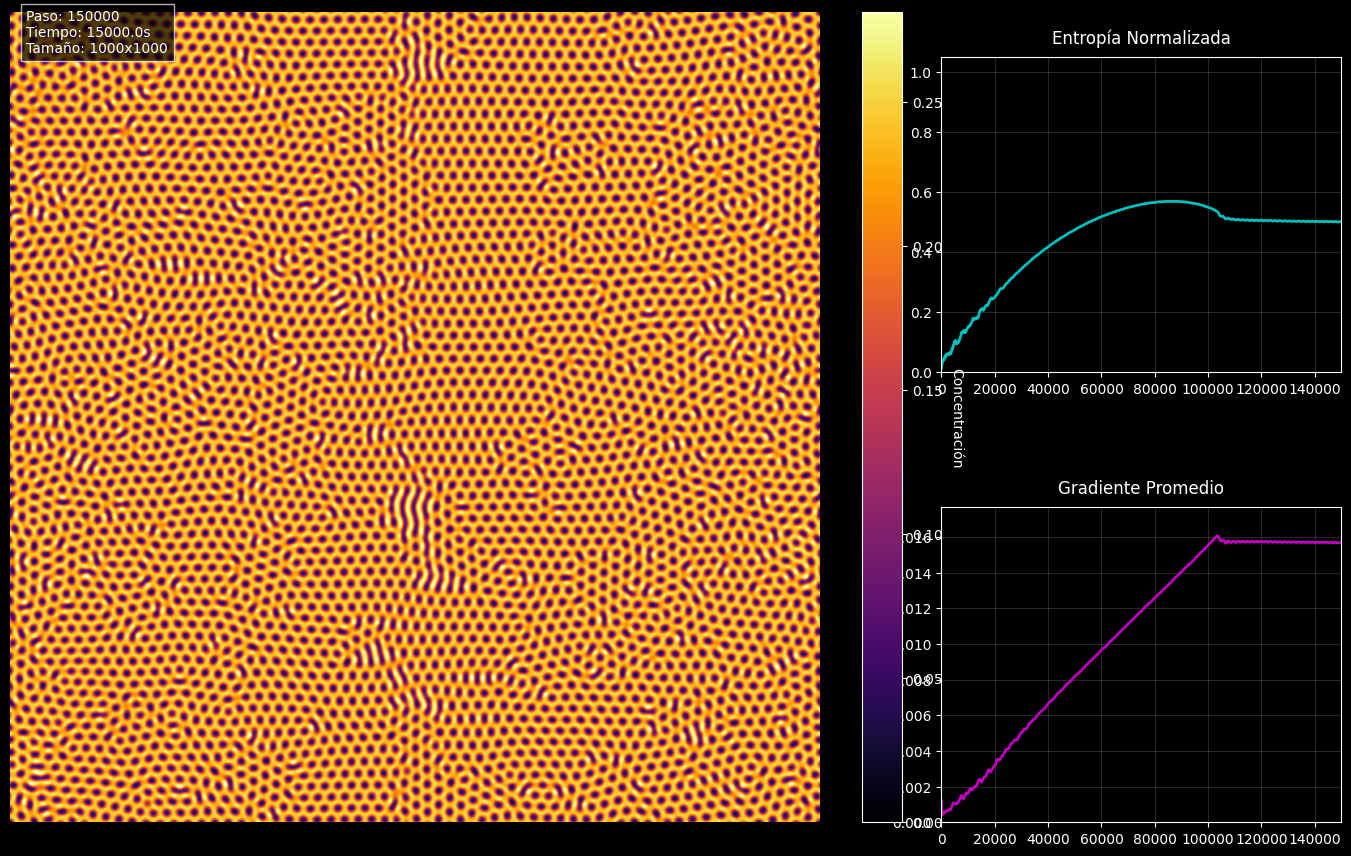

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter
import glob
import os
from datetime import datetime
from google.colab import files
from IPython.display import HTML

# ===== CONFIGURACIÓN PRINCIPAL CON POSICIONES ABSOLUTAS =====
plt.style.use('dark_background')
fig = plt.figure(figsize=(16, 9), facecolor='black')

# Definir posiciones absolutas para cada subplot
left_main = 0.05
bottom_main = 0.05
width_main = 0.65
height_main = 0.90

left_metrics = 0.72
bottom_entropy = 0.55
bottom_gradient = 0.05
width_metrics = 0.25
height_metrics = 0.35

ax_main = fig.add_axes([left_main, bottom_main, width_main, height_main])
ax_entropy = fig.add_axes([left_metrics, bottom_entropy, width_metrics, height_metrics])
ax_gradient = fig.add_axes([left_metrics, bottom_gradient, width_metrics, height_metrics])

# Paleta de colores
cmap = plt.get_cmap('inferno')
cmap.set_under('black')
cmap.set_over('white')

# ===== FUNCIONES AUXILIARES =====
def find_simulation_folder():
    folders = sorted(glob.glob("BZ_Geometry_*"),
                   key=lambda x: os.path.getmtime(x),
                   reverse=True)
    return folders[0] if folders else None

def load_metrics(folder):
    metrics_file = f"{folder}/metrics.csv"
    if os.path.exists(metrics_file):
        try:
            data = np.genfromtxt(metrics_file, delimiter=',',
                               skip_header=1,
                               names=['step', 'entropy', 'gradient'])
            if np.max(data['entropy']) > 1:
                data['entropy'] = data['entropy'] / np.max(data['entropy'])
            return data
        except:
            return None
    return None

# ===== DETECCIÓN DE SIMULACIÓN =====
simulation_folder = find_simulation_folder()
if not simulation_folder:
    raise FileNotFoundError("No se encontraron carpetas de simulación BZ_*")

print(f"\nProcesando simulación en: {simulation_folder}")

geometry_type = simulation_folder.split('_')[-1] if '_' in simulation_folder else '5'
geometry_names = {
    '1': 'Focos Circulares',
    '2': 'Línea Horizontal',
    '3': 'Cuadrado Central',
    '4': 'Patrón Hexagonal',
    '5': 'Cruz Central'
}
geometry_name = geometry_names.get(geometry_type, f"Geometría {geometry_type}")

# ===== CARGA DE DATOS CORREGIDA =====
csv_files = sorted(glob.glob(f"{simulation_folder}/bz_*.csv"),
                   key=lambda x: int(''.join(filter(str.isdigit, os.path.basename(x)))))

if not csv_files:
    raise FileNotFoundError(f"No se encontraron archivos de datos en {simulation_folder}")

# Cargar primer frame correctamente
sample_data = np.loadtxt(csv_files[0], delimiter=',')
if sample_data.ndim != 2:
    # Si el archivo tiene múltiples dimensiones, tomar solo la primera matriz 2D
    sample_data = sample_data.reshape(-1, sample_data.shape[-1])[0].reshape(-1, -1)

N = sample_data.shape[0]
print(f"Dimensiones de la simulación: {N}x{N}")

# Ajustar tamaño de figura basado en el tamaño de la malla
aspect_ratio = N / N  # Asumiendo malla cuadrada
fig.set_size_inches(16, 9 * aspect_ratio)

# Pre-cálculo de los límites de color CORREGIDO
print("\nCalculando rangos de color...")
sample_size = min(100, len(csv_files))
sample_indices = np.linspace(0, len(csv_files)-1, sample_size, dtype=int)
sample_data_list = []

for i in sample_indices:
    data = np.loadtxt(csv_files[i], delimiter=',')
    if data.ndim != 2:
        data = data.reshape(-1, data.shape[-1])[0].reshape(N, N)
    sample_data_list.append(data)

all_data = np.concatenate([d.flatten() for d in sample_data_list])
global_min = np.percentile(all_data, 1)
global_max = np.percentile(all_data, 99)
print(f"Rango de color fijado: {global_min:.2f} - {global_max:.2f}")

# Carga de métricas
metrics_data = load_metrics(simulation_folder)
if metrics_data is not None:
    max_step = metrics_data['step'][-1] if len(metrics_data['step']) > 0 else 100
    max_grad = np.max(metrics_data['gradient']) * 1.1 if len(metrics_data['gradient']) > 0 else 1
else:
    max_step = 100
    max_grad = 1

# ===== CONFIGURACIÓN DE VIDEO =====
output_name = f"BZ_{geometry_name.replace(' ', '_')}_{N}x{N}.mp4"

writer = FFMpegWriter(
    fps=20,
    codec='libx264',
    bitrate=8000,
    metadata={
        'title': f'BZ Simulation - {geometry_name}',
        'grid_size': f'{N}x{N}'
    },
    extra_args=[
        '-pix_fmt', 'yuv420p',
        '-profile:v', 'baseline',
        '-level', '3.0',
        '-crf', '18',
        '-preset', 'slow'
    ]
)

# ===== VISUALIZACIÓN INICIAL =====
ax_main.axis('off')
img = ax_main.imshow(sample_data, cmap=cmap,
                   vmin=global_min, vmax=global_max,
                   interpolation='bilinear',
                   origin='lower',
                   extent=[0, N, 0, N])

cbar = fig.colorbar(img, ax=ax_main, fraction=0.046, pad=0.04)
cbar.set_label('Concentración', rotation=270, labelpad=15, color='white')
cbar.ax.yaxis.set_tick_params(color='white')
plt.setp(cbar.ax.get_yticklabels(), color='white')

if metrics_data is not None:
    entropy_line, = ax_entropy.plot([], [], 'c-', lw=2)
    gradient_line, = ax_gradient.plot([], [], 'm-', lw=2)

    ax_entropy.set_title('Entropía Normalizada', color='white', pad=10)
    ax_entropy.set_ylim(0, 1.05)
    ax_entropy.set_xlim(0, max_step)
    ax_entropy.grid(alpha=0.3, color='gray')
    ax_entropy.tick_params(colors='white')

    ax_gradient.set_title('Gradiente Promedio', color='white', pad=10)
    ax_gradient.set_ylim(0, max_grad)
    ax_gradient.set_xlim(0, max_step)
    ax_gradient.grid(alpha=0.3, color='gray')
    ax_gradient.tick_params(colors='white')

info_text = ax_main.text(0.02, 0.95, '', transform=ax_main.transAxes,
                        color='white', fontsize=10,
                        bbox=dict(facecolor='black', alpha=0.7))

# ===== FUNCIÓN DE ACTUALIZACIÓN =====
def update_frame(idx):
    try:
        # Cargar y preparar datos
        data = np.loadtxt(csv_files[idx], delimiter=',')
        if data.ndim != 2:
            data = data.reshape(-1, data.shape[-1])[0].reshape(N, N)

        step = int(''.join(filter(str.isdigit, os.path.basename(csv_files[idx]))))
        time = step * 0.1

        img.set_array(data)
        info_text.set_text(f"Paso: {step}\nTiempo: {time:.1f}s\nTamaño: {N}x{N}")

        if metrics_data is not None:
            current_idx = min(idx, len(metrics_data['step'])-1)
            entropy_line.set_data(metrics_data['step'][:current_idx+1],
                                metrics_data['entropy'][:current_idx+1])
            gradient_line.set_data(metrics_data['step'][:current_idx+1],
                                 metrics_data['gradient'][:current_idx+1])

        return [img, info_text, entropy_line, gradient_line]

    except Exception as e:
        print(f"\nError en frame {idx}: {str(e)}")
        raise e

# ===== GENERACIÓN DE VIDEO =====
print("\nIniciando renderizado...")
try:
    with writer.saving(fig, output_name, dpi=120):
        writer.grab_frame()  # Primer frame

        for idx in range(1, len(csv_files)):
            update_frame(idx)
            writer.grab_frame()

            if (idx+1) % 50 == 0 or idx == len(csv_files)-1:
                print(f"\rProgreso: {idx+1}/{len(csv_files)} ({100*(idx+1)/len(csv_files):.1f}%)", end='')

    print(f"\n\nVideo generado exitosamente: {output_name}")

    if 'google.colab' in str(get_ipython()):
        files.download(output_name)
    else:
        print(f"Archivo guardado en: {os.path.abspath(output_name)}")

except Exception as e:
    print(f"\nError al generar video: {str(e)}")
    from matplotlib.animation import FuncAnimation
    anim = FuncAnimation(fig, update_frame, frames=min(100, len(csv_files)),
                        interval=50, blit=True)
    plt.close()
    HTML(anim.to_html5_video())

In [ ]:
import shutil
from google.colab import files

# Comprimir la carpeta como un archivo zip
shutil.make_archive('/content/BZ_Geometry_1', 'zip', '/content/BZ_Geometry_1')

# Descargar el archivo zip
files.download('/content/BZ_Geometry_1.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import shutil
from google.colab import drive

drive.mount('/content/drive')

# Comprimir y guardar en Drive
shutil.make_archive('/content/drive/MyDrive/BZ_Geometry_1', 'zip', '/content/BZ_Geometry_1')


Mounted at /content/drive


'/content/drive/MyDrive/BZ_Geometry_1.zip'